In [9]:
import numpy as np 
from sklearn.datasets import make_moons, make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [10]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.w1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
        self.loss_history = []
        self.accuracy_history = []
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, X): #z1= x1*w1 + b1
        self.z1 = np.dot(X, self.w1) + self.b1 # input and first hidden layer
        self.a1 = self.sigmoid(self.z1) # activation function
        self.z2 = np.dot(self.a1, self.w2) + self.b2 # first hidden layer after activation and output layer
        self.a2 = self.sigmoid(self.z2) # output layer after activation
        return self.a2
    
    def compute_loss(self, y_true, y_pred): #y_true is the actual label and y_pred is the output label
        """
        Compute the binary cross-entropy loss.
        The Equation for binary cross-entropy loss is:
        L(y_true, y_pred) = -1/m * Σ [y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred)]
        where
        Args:
            y_true (np.ndarray): True labels (shape: (n_samples, n_classes)).
            y_pred (np.ndarray): Predicted probabilities (shape: (n_samples, n_classes)).
        Returns:
            float: The computed loss value.
        """

        m = y_true.shape[0]
        loss = -1/m * np.sum(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))
        return loss 

    def backward(self, X, y_true, y_pred, lr):
        m = X.shape[0]

        # Output layer error
        dz2 = y_pred - y_true  # (n_samples, n_outputs)
        dw2 = np.dot(self.a1.T, dz2) / m  # (hidden_size, output_size)
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # Hidden layer error
        da1 = np.dot(dz2, self.w2.T)  # (n_samples, hidden_size)
        dz1 = da1 * self.sigmoid_derivative(self.a1)  # (n_samples, hidden_size)
        dw1 = np.dot(X.T, dz1) / m  # (input_size, hidden_size)
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.w2 -= lr * dw2
        self.b2 -= lr * db2
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
    def predict(self, X):
        y_pred = self.forward(X)
        return np.round(y_pred)
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    
    def train(self, X, y, X_val, y_val, epochs=1000, lr=0.01, batch_size=None, verbose=True):
        if batch_size is None:
            batch_size = X.shape[0]
        n_batches = int(np.ceil(X.shape[0] / batch_size))


        for epoch in range(epochs):
            
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0

            for batch in range(n_batches):

                start = batch * batch_size
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                output = self.forward(X_batch)
                loss = self.compute_loss(y_batch, output)
                epoch_loss += loss
                self.backward(X_batch, y_batch, output, lr)

            epoch_loss /= n_batches
            self.loss_history.append(epoch_loss)

            train_pred = self.predict(X)
            train_acc = self.accuracy(y, train_pred)

            val_pred = self.predict(X_val)
            val_acc = self.accuracy(y_val, val_pred)
            self.accuracy_history.append((train_acc, val_acc))

            if verbose and epoch % (epochs // 10) == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


In [11]:
def generate_data(n_samples=1000, noise=0.2, random_state=42):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    n_samples = X.shape[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    return X_train, y_train, X_test, y_test

In [12]:
def decision_boundary(model, X, y, title):
    """
    Plot the decision boundary of a trained model along with the data points.
    
    Args:
        model: Trained neural network model with predict method
        X (np.ndarray): Input features (n_samples, 2)
        y (np.ndarray): True labels (n_samples, 1) or (n_samples,)
        title (str): Title for the plot
    """
    # Create a mesh grid for plotting decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Use smaller step size for smoother boundaries
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh grid
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot decision boundary with custom colors
    colors = ['#FFAAAA', '#AAAAFF']  # Light red and light blue
    plt.contourf(xx, yy, Z, levels=1, colors=colors, alpha=0.6)
    
    # Add contour lines for better visualization
    plt.contour(xx, yy, Z, levels=1, colors='black', linestyles='--', linewidths=1)
    
    # Ensure y is flattened for scatter plot
    y_flat = y.flatten() if y.ndim > 1 else y
    
    # Plot data points with different colors for each class
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y_flat, 
                         cmap=plt.cm.RdYlBu, edgecolors='black', 
                         marker='o', s=50, alpha=0.8)
    
    # Add colorbar
    plt.colorbar(scatter)
    
    # Labels and title
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Set equal aspect ratio for better visualization
    plt.axis('equal')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [13]:
def plot_training_history(loss_history, accuracy_history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(loss_history, label = 'Training Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(['Training Loss'])
    ax2.plot([acc[0] for acc in accuracy_history], label = 'Training Accuracy')
    ax2.plot([acc[1] for acc in accuracy_history], label = 'Validation Accuracy')
    ax2.set_title('Accuracy History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.suptitle(title)
    plt.tight_layout()  

In [14]:
def run_experiment(X_train, y_train, X_val, y_val, input_size, hidden_size, output_size, epochs=1000, lr=0.01, batch_size=None):
    model = NeuralNetwork(input_size, hidden_size, output_size)
    model.train(X_train, y_train, X_val, y_val, epochs=epochs, lr=lr, batch_size=batch_size)
    
    train_pred = model.predict(X_train)
    train_acc = model.accuracy(y_train, train_pred)

    val_pred = model.predict(X_val)
    val_acc = model.accuracy(y_val, val_pred)

    print(f"Final Train Accuracy: {train_acc:.4f}, Final Validation Accuracy: {val_acc:.4f}")
    
    plot_training_history(model.loss_history, model.accuracy_history, "Training History")
    decision_boundary(model, X_train, y_train.flatten(), "Decision Boundary on Training Data")
    
    return model 

Running learning rate experiment...

--- Testing Learning Rate: 0.01 ---
Epoch 0: Loss: 0.9952, Train Acc: 0.4763, Val Acc: 0.4850
Epoch 100: Loss: 0.3537, Train Acc: 0.8525, Val Acc: 0.8200
Epoch 200: Loss: 0.3129, Train Acc: 0.8675, Val Acc: 0.8500
Epoch 300: Loss: 0.3038, Train Acc: 0.8700, Val Acc: 0.8600
Epoch 400: Loss: 0.3006, Train Acc: 0.8712, Val Acc: 0.8650
Epoch 500: Loss: 0.2988, Train Acc: 0.8738, Val Acc: 0.8650
Epoch 600: Loss: 0.2972, Train Acc: 0.8750, Val Acc: 0.8650
Epoch 700: Loss: 0.2955, Train Acc: 0.8750, Val Acc: 0.8650
Epoch 800: Loss: 0.2937, Train Acc: 0.8762, Val Acc: 0.8650
Epoch 900: Loss: 0.2916, Train Acc: 0.8762, Val Acc: 0.8700
Epoch 999: Loss: 0.2893, Train Acc: 0.8775, Val Acc: 0.8700
Final Train Accuracy: 0.8775, Final Validation Accuracy: 0.8700


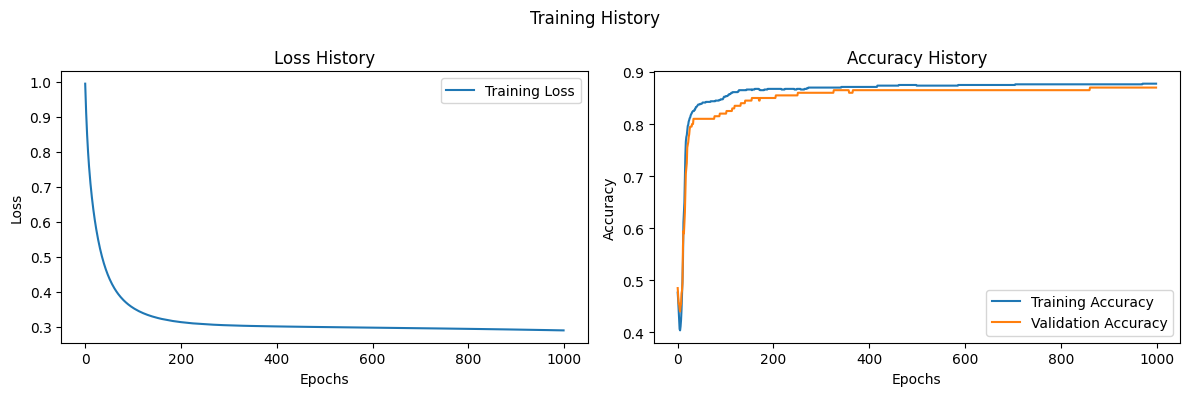

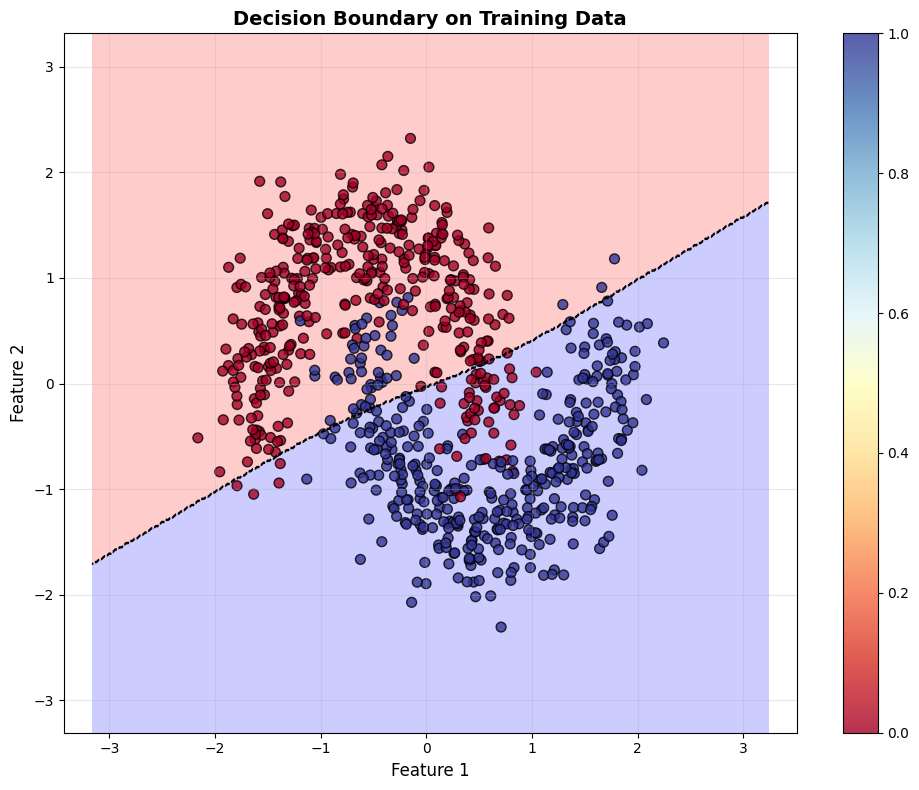


--- Testing Learning Rate: 0.001 ---
Epoch 0: Loss: 0.5525, Train Acc: 0.8300, Val Acc: 0.8400
Epoch 100: Loss: 0.5023, Train Acc: 0.8638, Val Acc: 0.8450
Epoch 200: Loss: 0.4644, Train Acc: 0.8650, Val Acc: 0.8550
Epoch 300: Loss: 0.4340, Train Acc: 0.8700, Val Acc: 0.8700
Epoch 400: Loss: 0.4094, Train Acc: 0.8700, Val Acc: 0.8650
Epoch 500: Loss: 0.3896, Train Acc: 0.8712, Val Acc: 0.8700
Epoch 600: Loss: 0.3736, Train Acc: 0.8675, Val Acc: 0.8650
Epoch 700: Loss: 0.3607, Train Acc: 0.8700, Val Acc: 0.8600
Epoch 800: Loss: 0.3503, Train Acc: 0.8700, Val Acc: 0.8600
Epoch 900: Loss: 0.3420, Train Acc: 0.8700, Val Acc: 0.8600
Epoch 999: Loss: 0.3353, Train Acc: 0.8700, Val Acc: 0.8600
Final Train Accuracy: 0.8700, Final Validation Accuracy: 0.8600


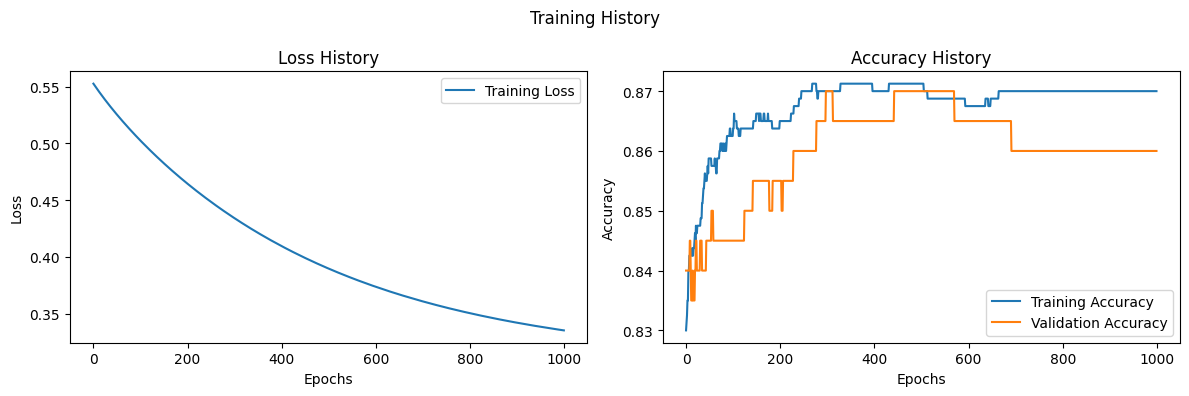

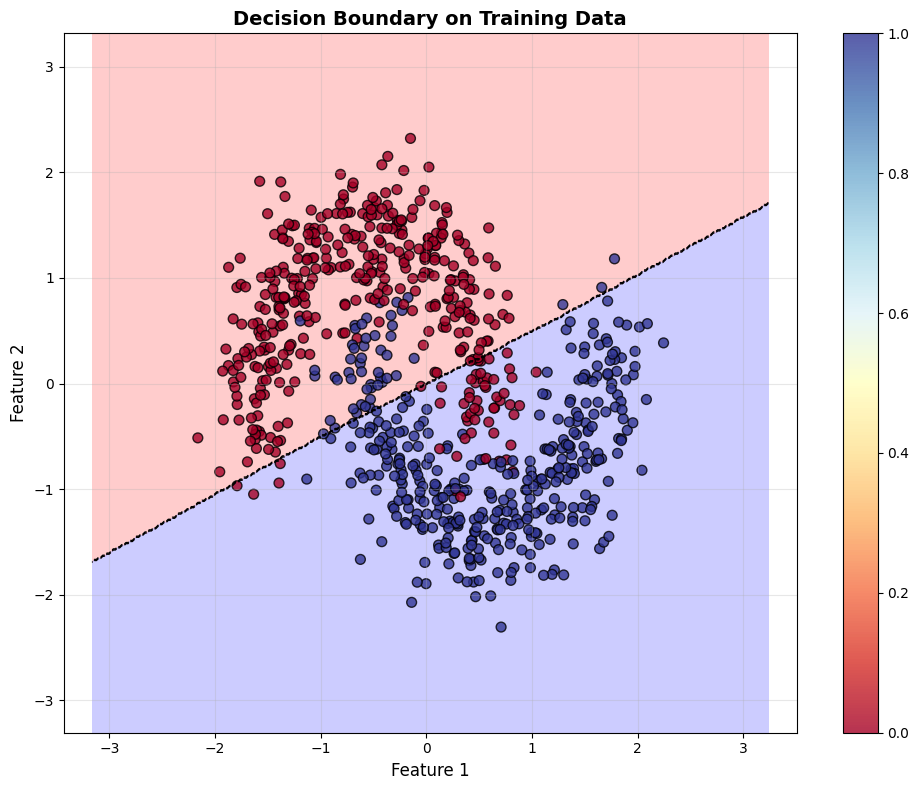


--- Testing Learning Rate: 0.0001 ---
Epoch 0: Loss: 0.6971, Train Acc: 0.5212, Val Acc: 0.5100
Epoch 100: Loss: 0.6687, Train Acc: 0.5837, Val Acc: 0.5650
Epoch 200: Loss: 0.6451, Train Acc: 0.6362, Val Acc: 0.6200
Epoch 300: Loss: 0.6252, Train Acc: 0.6713, Val Acc: 0.6500
Epoch 400: Loss: 0.6083, Train Acc: 0.6975, Val Acc: 0.6850
Epoch 500: Loss: 0.5938, Train Acc: 0.7200, Val Acc: 0.6950
Epoch 600: Loss: 0.5811, Train Acc: 0.7275, Val Acc: 0.7150
Epoch 700: Loss: 0.5699, Train Acc: 0.7462, Val Acc: 0.7450
Epoch 800: Loss: 0.5599, Train Acc: 0.7625, Val Acc: 0.7550
Epoch 900: Loss: 0.5508, Train Acc: 0.7700, Val Acc: 0.7650
Epoch 999: Loss: 0.5426, Train Acc: 0.7850, Val Acc: 0.7650
Final Train Accuracy: 0.7850, Final Validation Accuracy: 0.7650


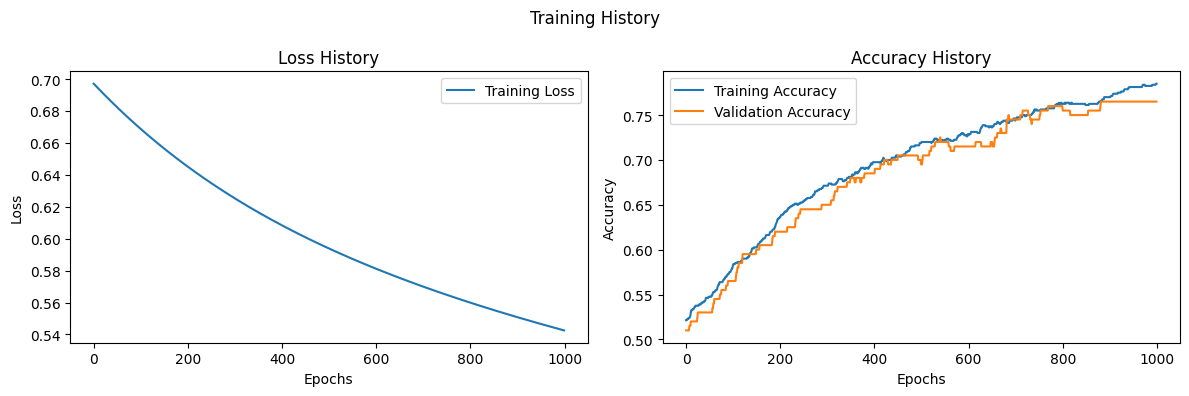

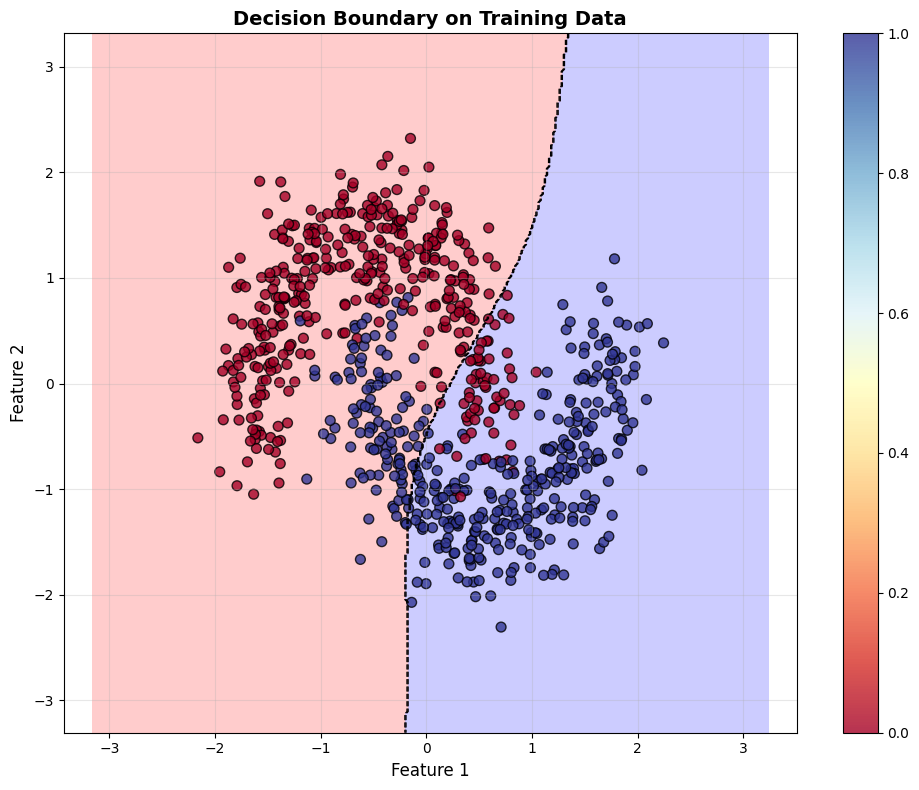



Running batch size experiment...

--- Testing Batch Size: 16 ---
Epoch 0: Loss: 0.6612, Train Acc: 0.5825, Val Acc: 0.5250
Epoch 100: Loss: 0.3066, Train Acc: 0.8700, Val Acc: 0.8550
Epoch 200: Loss: 0.3008, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 300: Loss: 0.2986, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 400: Loss: 0.2971, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 500: Loss: 0.2959, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 600: Loss: 0.2949, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 700: Loss: 0.2941, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 800: Loss: 0.2934, Train Acc: 0.8712, Val Acc: 0.8650
Epoch 900: Loss: 0.2928, Train Acc: 0.8712, Val Acc: 0.8650
Epoch 999: Loss: 0.2923, Train Acc: 0.8712, Val Acc: 0.8650
Final Train Accuracy: 0.8712, Final Validation Accuracy: 0.8650


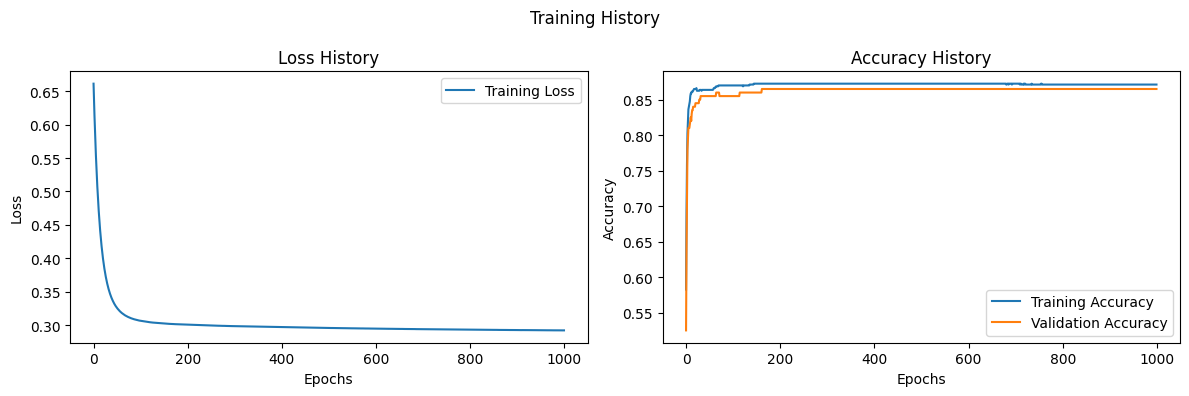

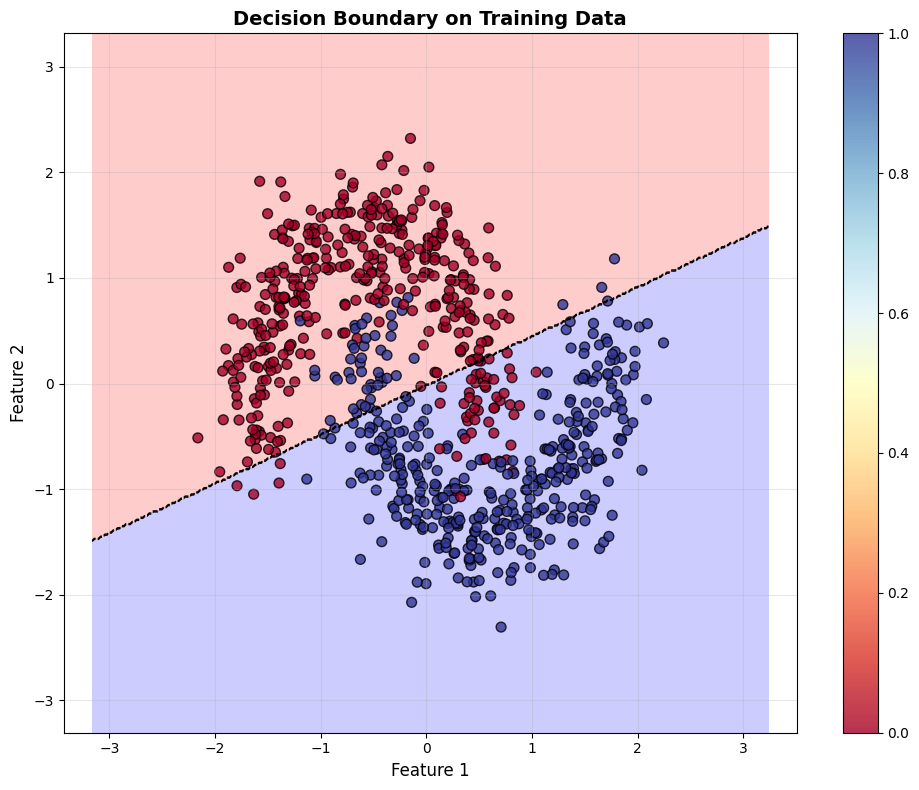


--- Testing Batch Size: 32 ---
Epoch 0: Loss: 1.1420, Train Acc: 0.1400, Val Acc: 0.1650
Epoch 100: Loss: 0.3367, Train Acc: 0.8588, Val Acc: 0.8250
Epoch 200: Loss: 0.3088, Train Acc: 0.8662, Val Acc: 0.8600
Epoch 300: Loss: 0.3026, Train Acc: 0.8700, Val Acc: 0.8600
Epoch 400: Loss: 0.3007, Train Acc: 0.8738, Val Acc: 0.8600
Epoch 500: Loss: 0.2996, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 600: Loss: 0.2987, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 700: Loss: 0.2978, Train Acc: 0.8738, Val Acc: 0.8650
Epoch 800: Loss: 0.2969, Train Acc: 0.8738, Val Acc: 0.8650
Epoch 900: Loss: 0.2960, Train Acc: 0.8738, Val Acc: 0.8650
Epoch 999: Loss: 0.2951, Train Acc: 0.8738, Val Acc: 0.8650
Final Train Accuracy: 0.8738, Final Validation Accuracy: 0.8650


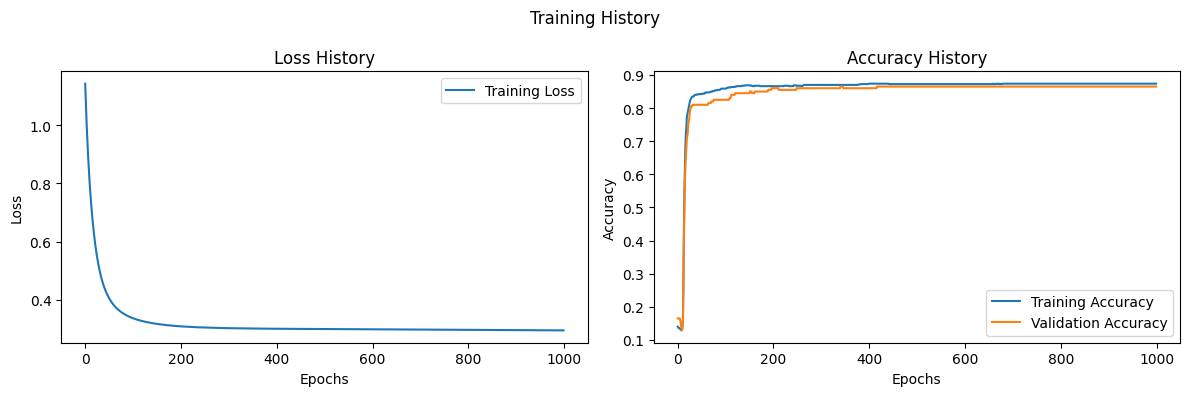

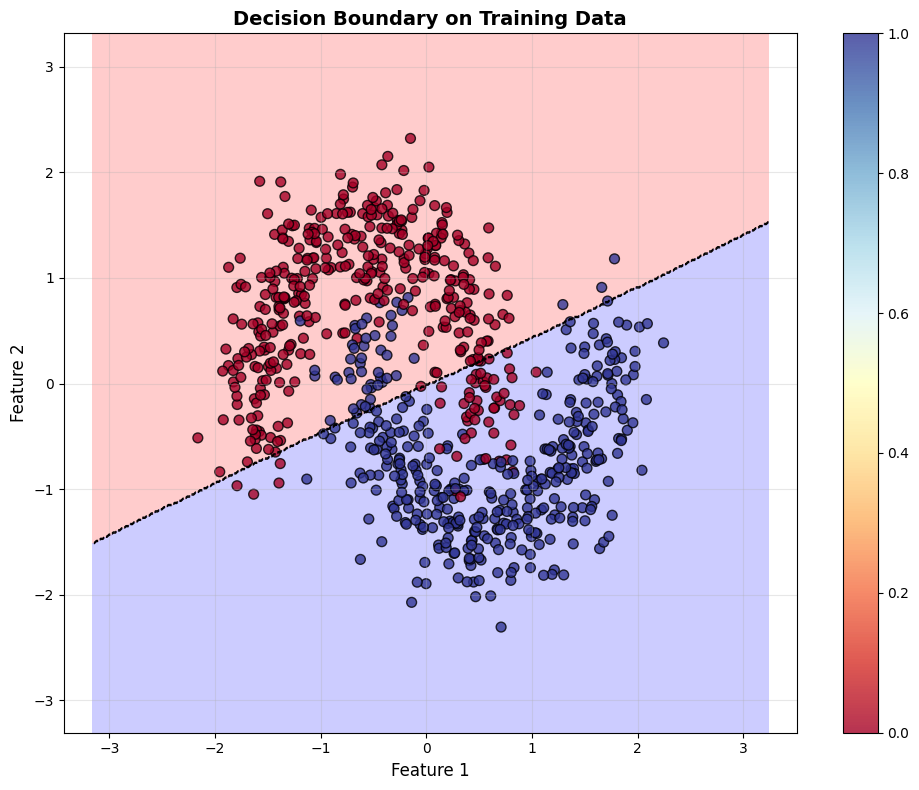


--- Testing Batch Size: 64 ---
Epoch 0: Loss: 0.5982, Train Acc: 0.7500, Val Acc: 0.7150
Epoch 100: Loss: 0.4052, Train Acc: 0.8313, Val Acc: 0.7950
Epoch 200: Loss: 0.3441, Train Acc: 0.8562, Val Acc: 0.8250
Epoch 300: Loss: 0.3128, Train Acc: 0.8700, Val Acc: 0.8500
Epoch 400: Loss: 0.3094, Train Acc: 0.8675, Val Acc: 0.8550
Epoch 500: Loss: 0.3036, Train Acc: 0.8675, Val Acc: 0.8550
Epoch 600: Loss: 0.3012, Train Acc: 0.8712, Val Acc: 0.8500
Epoch 700: Loss: 0.2921, Train Acc: 0.8712, Val Acc: 0.8550
Epoch 800: Loss: 0.3024, Train Acc: 0.8712, Val Acc: 0.8600
Epoch 900: Loss: 0.2953, Train Acc: 0.8712, Val Acc: 0.8600
Epoch 999: Loss: 0.2927, Train Acc: 0.8712, Val Acc: 0.8600
Final Train Accuracy: 0.8712, Final Validation Accuracy: 0.8600


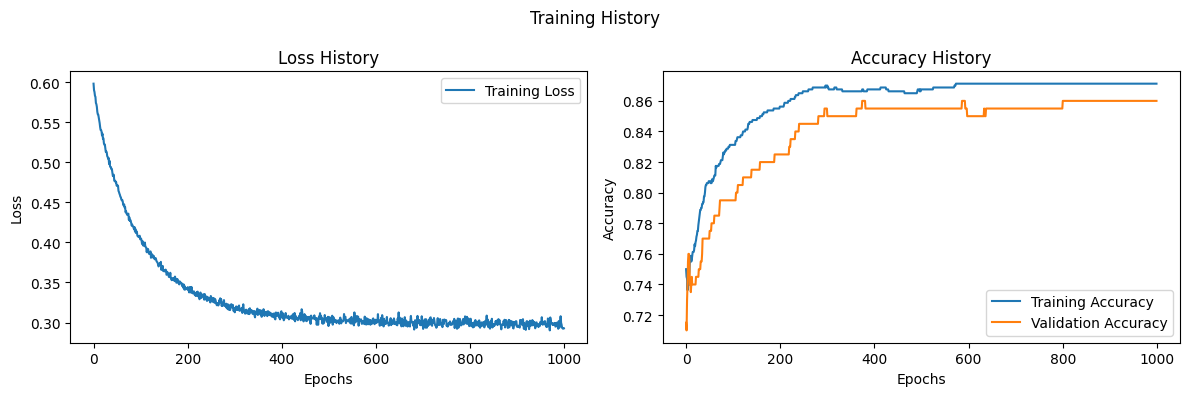

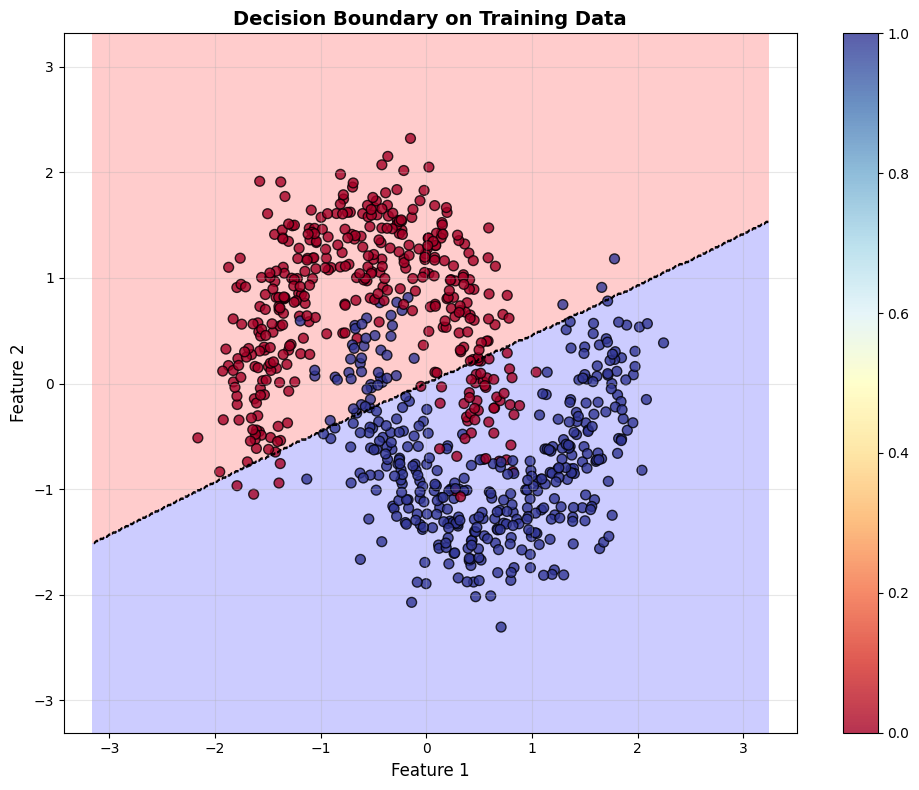



Running combined model experiment...
Epoch 0: Loss: 0.8611, Train Acc: 0.1963, Val Acc: 0.1750
Epoch 20: Loss: 0.3195, Train Acc: 0.8725, Val Acc: 0.8650
Epoch 40: Loss: 0.3026, Train Acc: 0.8762, Val Acc: 0.8700
Epoch 60: Loss: 0.2979, Train Acc: 0.8800, Val Acc: 0.8700
Epoch 80: Loss: 0.2933, Train Acc: 0.8812, Val Acc: 0.8700
Epoch 100: Loss: 0.2877, Train Acc: 0.8812, Val Acc: 0.8700
Epoch 120: Loss: 0.2805, Train Acc: 0.8862, Val Acc: 0.8850
Epoch 140: Loss: 0.2720, Train Acc: 0.8875, Val Acc: 0.8900
Epoch 160: Loss: 0.2617, Train Acc: 0.8912, Val Acc: 0.8900
Epoch 180: Loss: 0.2508, Train Acc: 0.8975, Val Acc: 0.9000
Epoch 199: Loss: 0.2402, Train Acc: 0.9050, Val Acc: 0.9100
Final Train Accuracy: 0.9050, Final Validation Accuracy: 0.9100


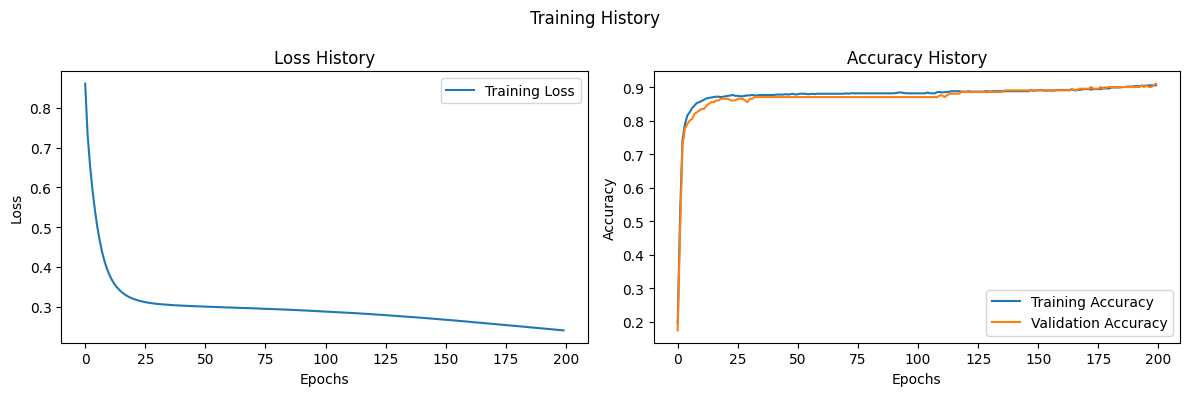

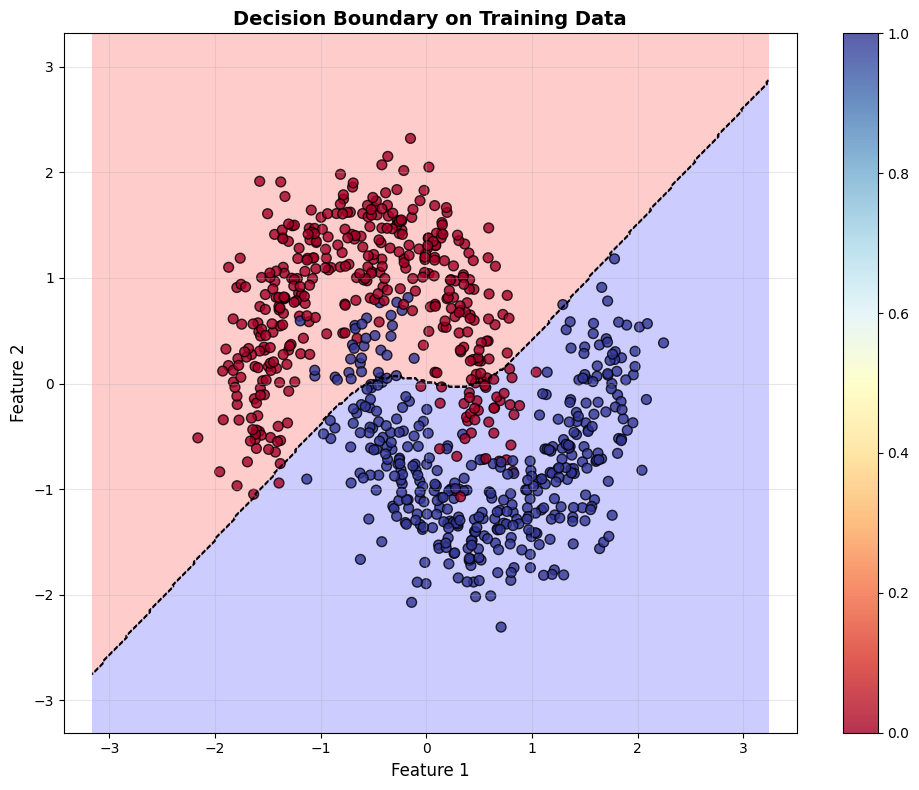

In [15]:
if __name__ == "__main__":
    # Generate data
    X_train, y_train, X_val, y_val = generate_data(n_samples=1000, noise=0.2)
    
    # Experiment with different learning rates
    print("Running learning rate experiment...")
    lr_rates = [0.01, 0.001, 0.0001]
    models = []
    
    for learning_rate in lr_rates: 
        print(f"\n--- Testing Learning Rate: {learning_rate} ---")
        params = {
            'input_size': X_train.shape[1],
            'hidden_size': 5,
            'output_size': 1,
            'epochs': 1000,
            'lr': learning_rate,
            'batch_size': 32
        }
        model = run_experiment(X_train, y_train, X_val, y_val, **params)
        models.append(model)

    # Experiment with different batch sizes
    print("\n\nRunning batch size experiment...")
    batch_sizes = [16, 32, 64]
    
    for batch_size in batch_sizes:
        print(f"\n--- Testing Batch Size: {batch_size} ---")
        params = {
            'input_size': X_train.shape[1],
            'hidden_size': 5,
            'output_size': 1,
            'epochs': 1000,
            'lr': 0.01,
            'batch_size': batch_size
        }
        model = run_experiment(X_train, y_train, X_val, y_val, **params)
        models.append(model)

    # Experiment with combined optimal parameters
    print("\n\nRunning combined model experiment...")
    params = {
        'input_size': X_train.shape[1],  # Added missing parameters
        'hidden_size': 5,
        'output_size': 1,
        'epochs': 200,
        'lr': 0.05,
        'batch_size': 16,
    }
    best_model = run_experiment(X_train, y_train, X_val, y_val, **params)